# Part ?? - **Predicció sobre el conjunt de test**

En aquest notebook farem la predicció sobre les imatges del conjunt de test.

### **1. Agregació de les imatges d'entrenament in validació**

In [24]:
### PYCHARM ###

import fastai
import torch
from fastai.vision.all import *
from fastai.callback.fp16 import *
import os
import shutil
import random
import pandas as pd

from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch


path = "dataset_CIFAR10"

In [3]:
### COLAB ###
"""
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
from fastbook import *
fastbook.setup_book()
from fastai.callback.fp16 import *
import os
import shutil
import random
import pandas as pd

!unzip /content/gdrive/MyDrive/dataset_CIFAR10.zip
path = "/content/"
"""

'\n! [ -e /content ] && pip install -Uqq fastbook\nimport fastbook\nfrom fastbook import *\nfastbook.setup_book()\nfrom fastai.callback.fp16 import *\nimport os\nimport shutil\nimport random\n\n!unzip /content/gdrive/MyDrive/dataset_CIFAR10.zip\npath = "/content/"\n'

In [4]:
#check if cuda is available
torch.cuda.is_available()

True

Per tal de fer l'entrenament final sobre més imatges, combinarem els conjunts de train i valid (el 90% de les imatges de validació les farem servir per entrenar).

In [5]:
if os.path.exists(path + "/train_test"):
    shutil.rmtree(path + "/train_test")

if os.path.exists(path + "/valid_test"):
    shutil.rmtree(path + "/valid_test")

#check if foler train_test exists in path folder
if not os.path.exists(path + "/train_test"):

    os.mkdir(path + "/valid_test")

    #copy all folders recursively from train to train_test
    shutil.copytree(path + "/train", path + "/train_test")

    #for each folder inside valid folder, print name
    for folder in os.listdir(path + "/validation"):

        #create folder inside valid_test with same name
        os.mkdir(path + "/valid_test/" + folder)

        # Get list of image files in folder
        files = [file for file in os.listdir(path+"/validation/"+folder) if file.endswith(".jpg")]

        # Calculate number of files to move to validation set
        num_valid = int(0.1 * len(files))

        # Randomly select files to move to validation set
        valid_files = random.sample(files, num_valid)

        # Move validation files to validation subfolder
        for file in valid_files:
            src = os.path.join(path, 'validation', folder, file)
            dst = os.path.join(path, 'valid_test', folder, file)
            shutil.copy(src, dst)

        # Move remaining files to train subfolder
        for file in files:
            if file not in valid_files:
                src = os.path.join(path, 'validation', folder, file)
                dst = os.path.join(path, 'train_test', folder, 'valid_'+file)
                shutil.copy(src, dst)

### **2. Carregar imatges d'entrenament**

In [6]:
#check if cuda is available
torch.cuda.is_available()

True

In [7]:
dls = ImageDataLoaders.from_folder(
    path=path,
    train='train_test',
    valid='valid_test',
    seed=42,
    bs = 64,
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

In [8]:
learn152 = vision_learner(dls, resnet152, metrics=[accuracy, error_rate]).to_fp16()
learn152.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.405097,0.331032,0.886000,0.114000,05:37
1,0.418379,0.302548,0.896000,0.104000,05:32
2,0.326044,0.266034,0.905000,0.095000,05:28
3,0.210088,0.214493,0.930000,0.070000,05:28
4,0.115753,0.177356,0.943000,0.057000,05:27
5,0.082675,0.168894,0.944000,0.056000,05:28


### **3. Carregar imatges de test**

Definim el directori on tenim les imatges de test guardades, i cridem ``get_image_files(path_test).sorted()`` (així ens assegurem que les imatges ja estan ordenades):

In [44]:
path_test = "test_unlabelled"
test_images = get_image_files(path_test).sorted()

Passem les imatges al ``dls`` (perquè apliqui les transformacions corresponents) i en fem les prediccions:

In [11]:
test_dl = dls.test_dl(test_images)
preds, _, decoded = learn152.get_preds(dl=test_dl, with_decoded=True)

Mostrem el vocabulari:

In [15]:
dls.vocab

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

La variable ``decoded`` conté la predicció en forma numèrica, per tant la passem a format string perquè sigui més fàcil avaluar els resultats:

In [23]:
decoded_str = [dls.vocab[i] for i in decoded]

Mostrem els resultats i comprovem que les prediccions estiguin ben fetes:

In [26]:
df = pd.DataFrame (decoded_str, columns = ['prediction'])
df

,prediction
0,airplane
1,deer
2,cat
3,cat
4,automobile
...,...
9995,ship
9996,automobile
9997,automobile
9998,cat


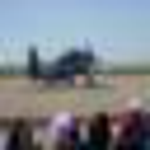

In [39]:
img = Image.open(path_test+'/0000.jpg')
img.resize((150, 150))

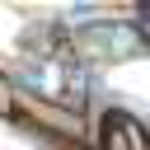

In [40]:
img = Image.open(path_test+'/0004.jpg')
img.resize((150, 150))

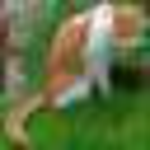

In [41]:
img = Image.open(path_test+'/9998.jpg')
img.resize((150, 150))

I guardem els resultats en format CSV:

In [43]:
df.to_csv('prediccions_test_IsaacdePalau_JoanSaló.csv')